## Spectrogram generation

In [1]:
get_ipython().run_line_magic('matplotlib', 'inline')

import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob

import pandas as pd
import numpy as np

import librosa


from tqdm import tqdm

In [2]:
DATA_PATH = 'MER_audio_taffc_dataset'
df = pd.read_csv('%s/panda_dataset_taffc_annotations.csv' % DATA_PATH)
df.head()

,Song,Quadrant
0,MT0000004637,Q3
1,MT0000011357,Q2
2,MT0000011975,Q2
3,MT0000040632,Q1
4,MT0000044741,Q3


In [3]:
df['filepath'] = DATA_PATH + '/' + df.Quadrant + '/' + df.Song + '.mp3'
df.head()


,Song,Quadrant,filepath
0,MT0000004637,Q3,MER_audio_taffc_dataset/Q3/MT0000004637.mp3
1,MT0000011357,Q2,MER_audio_taffc_dataset/Q2/MT0000011357.mp3
2,MT0000011975,Q2,MER_audio_taffc_dataset/Q2/MT0000011975.mp3
3,MT0000040632,Q1,MER_audio_taffc_dataset/Q1/MT0000040632.mp3
4,MT0000044741,Q3,MER_audio_taffc_dataset/Q3/MT0000044741.mp3


In [4]:
def create_spectrogram(wave_data, sample_rate, sample_rate_new = 16000):
    # downsample to fs = 16kHz 
    wave_data = librosa.core.resample(wave_data, 
                          sample_rate, 
                          sample_rate_new)

    sample_rate = sample_rate_new

    # normalize input amplitude
    wave_data = librosa.util.normalize(wave_data)  

    # bring audio to uniform lenth of appr. 30s
    wave_data = wave_data[:465984]


    # time-frequency transformation with Mel-scaling
    spectrogram = librosa.feature.melspectrogram(wave_data,
                                                 sr=sample_rate,
                                                 n_mels     = 80,
                                                 power      = 2.0,
                                                 norm       = 1)


    # transform to Decibel scale
    spectrogram = librosa.power_to_db(spectrogram)

    # re-shape to final segment size
    return spectrogram.astype(np.float32)

In [5]:
df['spectrogram'] = None

for index, row in tqdm(df.iterrows()):
    fileName = row['filepath']

    # load audio data
    wave_data, sample_rate = librosa.core.load(fileName, 
                                               sr    = None, 
                                               mono  = True, 
                                               dtype = np.float32)
    
    df.loc[index,'spectrogram'] = create_spectrogram(wave_data, sample_rate, 16000)

    print(fileName)

4/MT0030481897.mp3
/Users/somaf/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
827it [13:09,  1.22it/s]MER_audio_taffc_dataset/Q1/MT0030484925.mp3
/Users/somaf/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
828it [13:10,  1.17it/s]MER_audio_taffc_dataset/Q1/MT0030487841.mp3
/Users/somaf/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
829it [13:11,  1.24it/s]MER_audio_taffc_dataset/Q4/MT0030494794.mp3
/Users/somaf/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile faile

In [6]:
# save for later
df.to_pickle('MER_audio_taffc_dataset.pkl')

In [7]:

import IPython.display as ipd

idxList = df.index[df['Quadrant'] == "Q3"]
idx = idxList[101]

fileName = df.loc[idx,'filepath']

x, sample_rate = librosa.load(fileName, mono=True)
ipd.Audio(fileName)


/Users/somaf/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


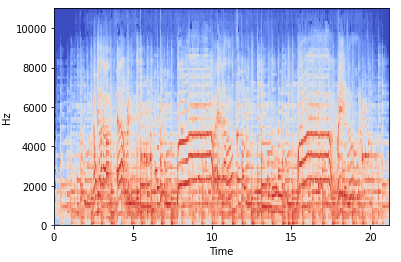

In [8]:

from librosa import display 

librosa.display.specshow(df.loc[idx,'spectrogram'], y_axis='linear', x_axis='time', hop_length=512, sr=sample_rate);


## Data augmentation

In [9]:
# noise injection
def noise_injected_data(data, noise_factor):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

In [10]:
# shifting time
def time_shifted_data(data, sampling_rate, shift_max, shift_direction):
    shift = np.random.randint(sampling_rate * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif self.shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    # Set to silence for heading/ tailing
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0
    return augmented_data

In [11]:
# pitch shift
def pitch_shifted_data(data, sampling_rate, pitch_factor):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [12]:
# speed change
def speed_changed_data(data, speed_factor):
    return librosa.effects.time_stretch(data, speed_factor)

In [13]:
idxList = df.index[df['Quadrant'] == "Q3"]
idx = idxList[101]

fileName = df.loc[idx,'filepath']

x, sample_rate = librosa.load(fileName, mono=True)
ipd.Audio(fileName)

/Users/somaf/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


In [14]:
ni_data = noise_injected_data(x, 0.005)
spec_temp = create_spectrogram(ni_data, sample_rate, 16000)

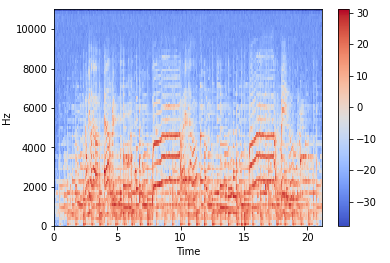

In [15]:
librosa.display.specshow(spec_temp, y_axis='linear', x_axis='time', hop_length=512, sr=sample_rate);
plt.colorbar()


In [23]:
sys.path.append(".")
from gtzan import GtzanData

In [25]:
x = GtzanData()

In [26]:
print(x.data)

[1, 2, 3, 4, 5]


,Song,Quadrant,filepath,spectrogram
0,MT0000004637,Q3,MER_audio_taffc_dataset/Q3/MT0000004637.mp3,"[[-53.401657, -53.401657, -47.589714, -45.6831..."
1,MT0000011357,Q2,MER_audio_taffc_dataset/Q2/MT0000011357.mp3,"[[-27.316246, -15.746821, -12.419839, -11.4409..."
2,MT0000011975,Q2,MER_audio_taffc_dataset/Q2/MT0000011975.mp3,"[[-36.16533, -25.712698, -20.417326, -13.17166..."
3,MT0000040632,Q1,MER_audio_taffc_dataset/Q1/MT0000040632.mp3,"[[-32.87751, -22.536217, -17.13093, -13.637753..."
4,MT0000044741,Q3,MER_audio_taffc_dataset/Q3/MT0000044741.mp3,"[[-42.08161, -35.54928, -17.71851, -5.7702646,..."
